In [5]:
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt 
import os 
import json
from collections import Counter 
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

In [6]:
init_path = "../../data/"
train_data = pd.read_csv(init_path + "train_data.csv")
test_data = pd.read_csv(init_path + "test_data.csv")
val_data = pd.read_csv(init_path + "val_data.csv")

def extract_data(data):
    X = data["Source"]
    y = data["Label"]
    return np.asarray(X), np.asarray(y)

X_train, y_train = extract_data(train_data)
y_train = y_train-1
X_test, y_test = extract_data(test_data)
y_test = y_test-1
X_val, y_val = extract_data(val_data)
y_val = y_val-1

print("Train labels ratio: ")
print(Counter(y_train.tolist()))

print("Test labels ratio: ")
print(Counter(y_test.tolist()))

print("Val labels ratio: ")
print(Counter(y_val.tolist()))

Train labels ratio: 
Counter({2: 12586, 1: 3298, 0: 152})
Test labels ratio: 
Counter({2: 2700, 1: 727, 0: 33})
Val labels ratio: 
Counter({2: 2725, 1: 702, 0: 32})


In [7]:
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_train = X_train.tolist()
X_train_encoded = tokenizer(X_train, padding=True, truncation=True, return_tensors='tf')
X_val = X_val.tolist()
X_val_encoded = tokenizer(X_val, padding=True, truncation=True, return_tensors='tf')
X_test = X_test.tolist()
X_test_encoded = tokenizer(X_test, padding=True, truncation=True, return_tensors='tf')

y_train_tensor = tf.convert_to_tensor(y_train)
y_val_tensor = tf.convert_to_tensor(y_val)
y_test_tensor = tf.convert_to_tensor(y_test)

/home/mallasailesh/.local/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
from sklearn.metrics import classification_report

# Load pretrained BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Load pre-trained BERT embeddings
X_train_bert = model.predict(X_train_encoded)[0]
X_val_bert = model.predict(X_val_encoded)[0]
X_test_bert = model.predict(X_test_encoded)[0]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


109/109 [==============================] - 1703s 16s/step


NameError: name 'LogisticRegression' is not defined

In [30]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression on top of BERT embeddings
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_bert, y_train)

LogisticRegression(max_iter=1000)

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

def get_metrics(ytrue, ypred, name):
    print(classification_report(ytrue, ypred, zero_division=1))
    ret = classification_report(ytrue, ypred, output_dict=True, zero_division=1)
    ConfusionMatrixDisplay.from_predictions(ytrue, ypred)
    plt.savefig(os.path.join(results_dir, f"confusion-{name}.png"), dpi=300)
    plt.show()
    print('\n\n')
    with open(os.path.join(results_dir, f"stats-{name}.json"), "w") as f:
        json.dump(ret, f, indent=4)


For train set: 

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       152
           1       1.00      0.00      0.00      3298
           2       0.78      1.00      0.88     12586

    accuracy                           0.78     16036
   macro avg       0.93      0.33      0.29     16036
weighted avg       0.83      0.78      0.69     16036



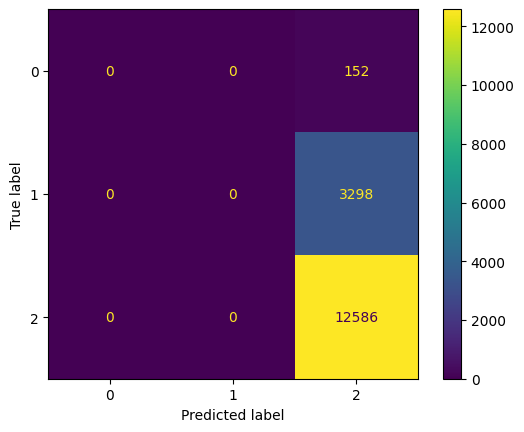





For validation set: 

              precision    recall  f1-score   support

           0       1.00      0.00      0.00        32
           1       1.00      0.00      0.00       702
           2       0.79      1.00      0.88      2725

    accuracy                           0.79      3459
   macro avg       0.93      0.33      0.29      3459
weighted avg       0.83      0.79      0.69      3459



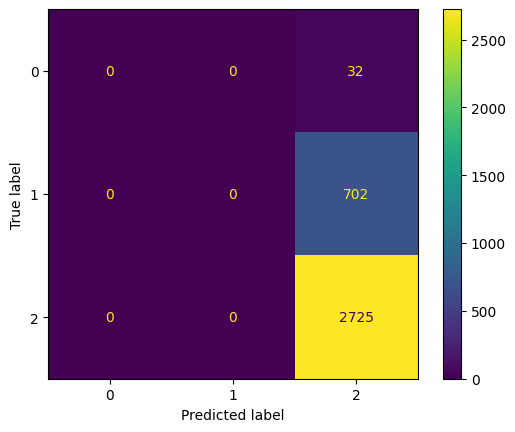





For test set: 

              precision    recall  f1-score   support

           0       1.00      0.00      0.00        33
           1       1.00      0.00      0.00       727
           2       0.78      1.00      0.88      2700

    accuracy                           0.78      3460
   macro avg       0.93      0.33      0.29      3460
weighted avg       0.83      0.78      0.68      3460



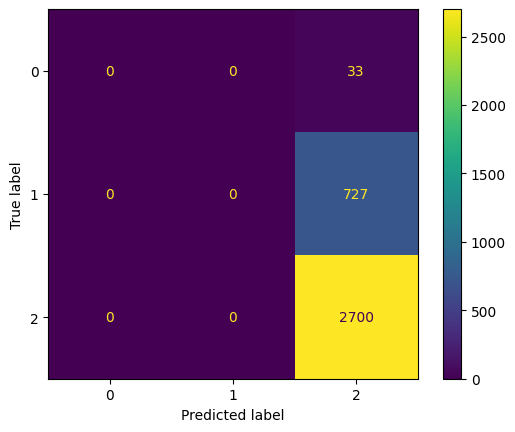

In [32]:
print("\nFor train set: \n")
y_pred = logreg.predict(X_train_bert)
get_metrics(y_train, y_pred, "train")

print("\nFor validation set: \n")
y_pred = logreg.predict(X_val_bert)
get_metrics(y_val, y_pred, "val")

print("\nFor test set: \n")
y_pred = logreg.predict(X_test_bert)
get_metrics(y_test, y_pred, "test")

### Here we can see only result 3 is being predicted ==> because of the imbalanced data . So, now we will be using "class wieghts" technique

In [19]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights

array([35.16666667,  1.62078027,  0.4247047 ])

In [20]:
logreg2 = LogisticRegression(max_iter=1000, class_weight={0: class_weights[0], 1: class_weights[1], 2: class_weights[2]})
logreg2.fit(X_train_bert, y_train)

LogisticRegression(class_weight={0: 35.166666666666664, 1: 1.620780270871235,
                                 2: 0.4247046983420732},
                   max_iter=1000)

In [22]:
def get_metrics2(ytrue, ypred, name):
    print(classification_report(ytrue, ypred, zero_division=1))
    ret = classification_report(ytrue, ypred, output_dict=True, zero_division=1)
    ConfusionMatrixDisplay.from_predictions(ytrue, ypred)
    plt.savefig(os.path.join(results_dir, f"confusion-classWeights_{name}.png"), dpi=300)
    plt.show()
    print('\n\n')
    with open(os.path.join(results_dir, f"stats-classWeights_{name}.json"), "w") as f:
        json.dump(ret, f, indent=4)


For train set: 

              precision    recall  f1-score   support

           0       0.01      0.45      0.02       152
           1       0.21      0.16      0.18      3298
           2       0.80      0.49      0.61     12586

    accuracy                           0.42     16036
   macro avg       0.34      0.37      0.27     16036
weighted avg       0.67      0.42      0.52     16036



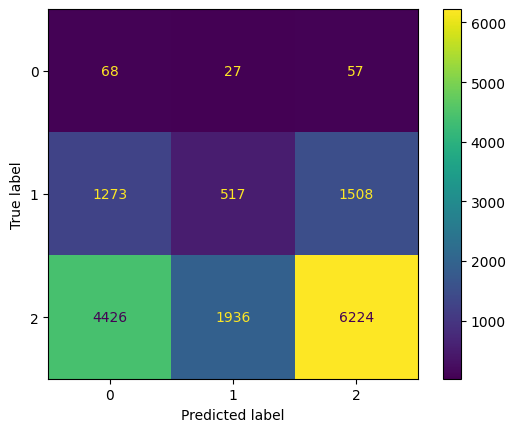





For validation set: 

              precision    recall  f1-score   support

           0       0.01      0.47      0.02        32
           1       0.19      0.15      0.17       702
           2       0.80      0.48      0.60      2725

    accuracy                           0.41      3459
   macro avg       0.33      0.37      0.26      3459
weighted avg       0.67      0.41      0.51      3459



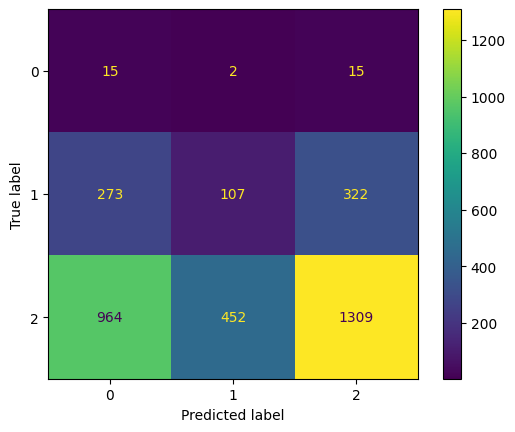





For test set: 

              precision    recall  f1-score   support

           0       0.01      0.42      0.02        33
           1       0.22      0.17      0.19       727
           2       0.80      0.49      0.61      2700

    accuracy                           0.42      3460
   macro avg       0.34      0.36      0.27      3460
weighted avg       0.67      0.42      0.51      3460



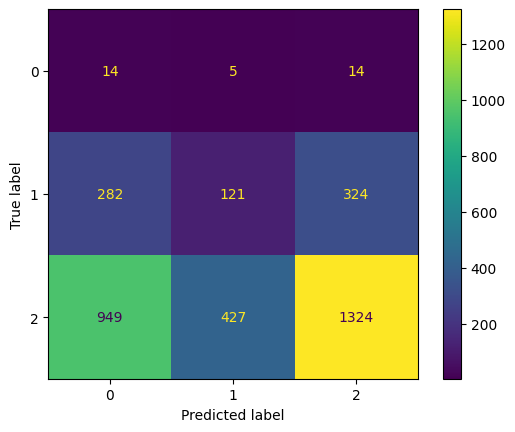

In [33]:
print("\nFor train set: \n")
y_pred = logreg2.predict(X_train_bert)
get_metrics2(y_train, y_pred, "train")

print("\nFor validation set: \n")
y_pred = logreg2.predict(X_val_bert)
get_metrics2(y_val, y_pred, "val")

print("\nFor test set: \n")
y_pred = logreg2.predict(X_test_bert)
get_metrics2(y_test, y_pred, "test")

In [24]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_bert, y_train_tensor)

DecisionTreeClassifier()

In [25]:
def get_metrics3(ytrue, ypred, name):
    print(classification_report(ytrue, ypred, zero_division=1))
    ret = classification_report(ytrue, ypred, output_dict=True, zero_division=1)
    ConfusionMatrixDisplay.from_predictions(ytrue, ypred)
    plt.savefig(os.path.join(results_dir, f"confusion-decisionTree_{name}.png"), dpi=300)
    plt.show()
    print('\n\n')
    with open(os.path.join(results_dir, f"stats-decisionTree_{name}.json"), "w") as f:
        json.dump(ret, f, indent=4)


For train set: 

              precision    recall  f1-score   support

           0       0.44      0.38      0.40       152
           1       0.62      0.54      0.58      3298
           2       0.88      0.91      0.89     12586

    accuracy                           0.83     16036
   macro avg       0.64      0.61      0.62     16036
weighted avg       0.82      0.83      0.82     16036



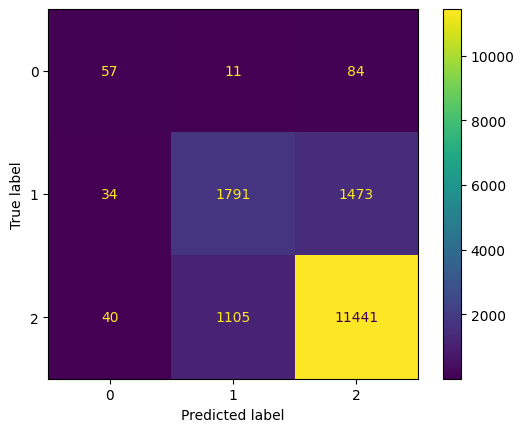





For validation set: 

              precision    recall  f1-score   support

           0       0.03      0.03      0.03        32
           1       0.23      0.27      0.25       702
           2       0.80      0.76      0.78      2725

    accuracy                           0.65      3459
   macro avg       0.35      0.35      0.35      3459
weighted avg       0.67      0.65      0.66      3459



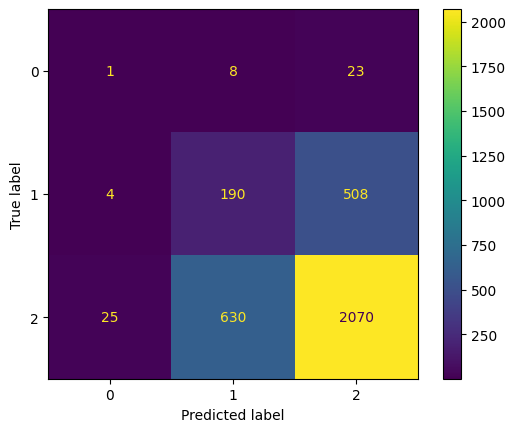





For test set: 

              precision    recall  f1-score   support

           0       0.06      0.06      0.06        33
           1       0.23      0.25      0.24       727
           2       0.79      0.77      0.78      2700

    accuracy                           0.66      3460
   macro avg       0.36      0.36      0.36      3460
weighted avg       0.67      0.66      0.66      3460



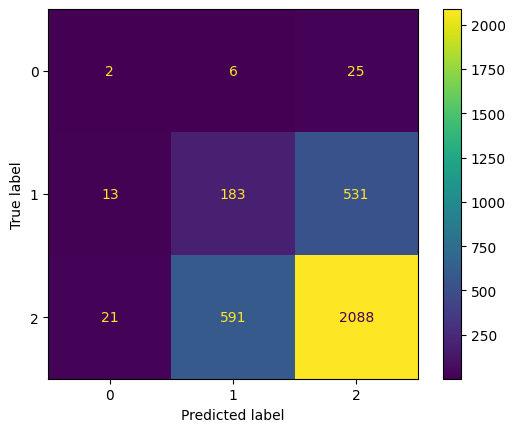

In [34]:
print("\nFor train set: \n")
y_pred = decision_tree.predict(X_train_bert)
get_metrics3(y_train, y_pred, "train")

print("\nFor validation set: \n")
y_pred = decision_tree.predict(X_val_bert)
get_metrics3(y_val, y_pred, "val")

print("\nFor test set: \n")
y_pred = decision_tree.predict(X_test_bert)
get_metrics3(y_test, y_pred, "test")